### Notebook applies several classic machine learning techniques on the cleaned SGCarMart dataset.

The models include ensemble learning technqiues, Neural Network, Non-parametric algorithms, etc.

In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd
import time

from src.transformers import *

from random import randrange
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

### Set below flag if this is for submission

In [3]:
is_submission = False

In [4]:
train = pd.read_csv("../data/processed/train.csv", sep=",")
test = pd.read_csv("../data/processed/test.csv", sep=",")

print("The shape of train is {}".format(train.shape))
print("The shape of test is {}".format(test.shape))

The shape of train is (16728, 55)
The shape of test is (5000, 54)


In [5]:
class PostProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = [
            "listing_id",
            "title",
            "model",
            "make",
            "make_model",
            "description",
            "original_reg_date",
            "reg_date",
            "category",
            "lifespan",
            "features",
            "accessories",
            "eco_category",
            "indicative_price",
            "reg_date_year",
            "reg_date_month",
            "coe_start_date",
            "coe_start_year",
            "coe_rebate",
            "dereg_value_computed",
            "engine_cap_bins",
            "price",
            "coe_text",
            "coe_expiry_days",
            "coe_expiry_date",
            "coe_start_date",
        ]
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        df = X.copy()
        df.loc[:, "last_reg_age"] = (
            datetime.now().year - pd.to_datetime(df.reg_date).dt.year
        )
        df.loc[:, "mileage_log"] = np.log(df.mileage)
        df = df.drop(self.columns_to_drop, axis=1, errors="ignore")
        return df

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipe = Pipeline(
    [
        ("add_cat", SplitValuesToColumn("category")),
        ("post_processing", PostProcessing()),
        (
            "ohe",
            OheCategorical(
                [
                    "type_of_vehicle",
                    "transmission",
                    "brand_rank",
                    "opc_scheme",
                    "fuel_type",
                    "vehicle_age_bins",
                ]
            ),
        ),
    ]
)

In [7]:
trainX = train
trainY = train.loc[:, "price"]

In [8]:
if not is_submission:
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        trainX, trainY, test_size=0.2, random_state=72
    )

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)

In [9]:
if is_submission:
    X_train = pipe.fit_transform(trainX)
    X_test = pipe.transform(test)
    y_train = trainY
else:
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)

print(f"X_Train:{X_train.shape}")

X_Train:(13382, 74)


In [10]:
def run_hpo(model, params, X, y):

    model_name = type(model()).__name__
    print(f"*** Running HPO for: {model_name}")
    model_tuning = GridSearchCV(
        estimator=model(), param_grid=params, cv=5, verbose=3, n_jobs=-1,
    )

    model_tuning.fit(X, y)
    print(f"Best Params {model_tuning.best_params_}")
    print(f"Best Score {model_tuning.best_score_}")
    print("")
    return model_tuning.best_params_


def Run(model, params, X, y):
    scores_train = []
    scores_test = []
    best_params = run_hpo(model, params, X, y)
    model_name = type(model()).__name__
    print(f"*** Training: {model_name}")
    start_time = int(time.time())
    for i in range(3):
        random = randrange(100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=random
        )

        best_model = model(**best_params)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)

        scores_train.append(mean_squared_error(y_train, y_pred_train, squared=False))
        scores_test.append(mean_squared_error(y_test, y_pred, squared=False))
    end_time = int(time.time())

    print("[Testing Error] Root Mean Squared  Error : ", np.mean(scores_test))
    print("[Training Error] Root Mean Squared  Error : ", np.mean(scores_train))
    print(f"Runtime: {(end_time-start_time)/3} seconds")
    return None

#### Define all the models with the paramter ranges that we want to tune.

In [11]:
models = [
    {
        "name": type(RandomForestRegressor()).__name__,
        "model": RandomForestRegressor,
        "params": {
            "max_depth": [10, 50, 100],
            "max_features": ["sqrt"],
            "n_estimators": [100, 200],
        },
    },
    {
        "name": type(GradientBoostingRegressor()).__name__,
        "model": GradientBoostingRegressor,
        "params": {
            "n_estimators": [500, 1000],
            "learning_rate": [0.01, 0.05],
            "max_depth": [5, 10],
            "max_features": ["sqrt"],
        },
    },
    {
        "name": type(Ridge()).__name__,
        "model": Ridge,
        "params": {
            "solver": ["svd", "cholesky", "lsqr", "sag"],
            "alpha": [0.00001, 0.0001, 0.01],
            "fit_intercept": [True, False],
            "normalize": [True, False],
        },
    },
    {
        "name": type(KNeighborsRegressor()).__name__,
        "model": KNeighborsRegressor,
        "params": {"n_neighbors": [1, 3, 5]},
    },
    {
        "name": type(MLPRegressor()).__name__,
        "model": MLPRegressor,
        "params": {
            "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (200, 20)],
            "activation": ["relu", "tanh", "logistic"],
            "alpha": [0.0001, 0.05],
            "learning_rate": ["constant", "adaptive"],
            "solver": ["adam"],
        },
    },
]

### Uncomment below to do hyperparameter tuning

In [12]:
# from sklearn.model_selection import train_test_split

# for model in models:
#     Run(model["model"], model["params"], X_train, y_train)
#     print("***")

### Select the best model with tuned hyper-parameters

In [13]:
best_model = RandomForestRegressor
best_params = {"max_depth": 50, "max_features": "sqrt", "n_estimators": 100}

### Selecting top features

We removed the features which are of low importance and re-trained our model on the reduced set of features

In [20]:
final_model = best_model(**best_params)
final_model.fit(X_train, y_train)


forest_importances = pd.Series(
    final_model.feature_importances_, index=list(X_train.columns)
)
remove_cols = list(
    forest_importances[forest_importances <= 0.01].reset_index()["index"].values
)

X_train = X_train[X_train.columns.difference(remove_cols)]
X_test = X_test[X_test.columns.difference(remove_cols)]

### Feature Importance

<AxesSubplot:>

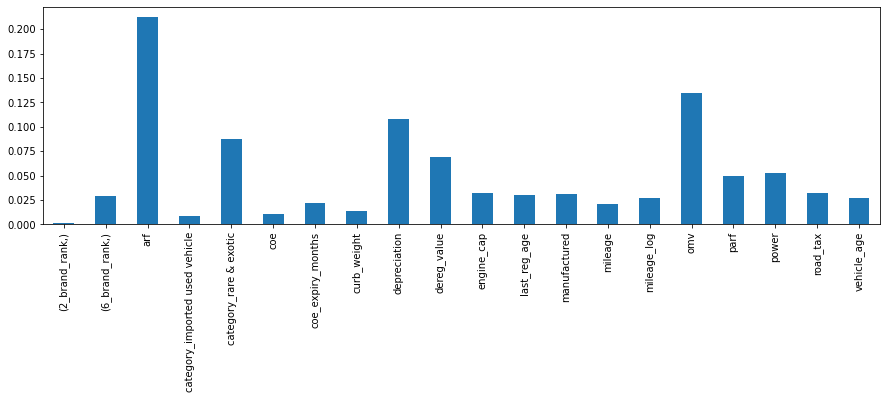

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

forest_importances = forest_importances[forest_importances >= 0.0005]

plt.figure(figsize=(15, 4))
forest_importances.plot.bar()

In [22]:
final_model = best_model(**best_params)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features='sqrt')

In [23]:
y_pred = final_model.predict(X_test)

In [26]:
# RMSE below will vary based on the random seed used
if not is_submission:
    print(mean_squared_error(y_test, y_pred, squared=False))

30052.894797204994


### Prepare file for submission

In [25]:
if is_submission:
    my_submission = pd.DataFrame({"Id": list(test.index), "Predicted": y_pred})
    my_submission.to_csv("submission.csv", index=False)